In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [5]:
df = pd.read_csv('../../eICU/training/finalData.csv')
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,143870,7.0,37.132325,44.0,86.0,111.000000,0.89,11.7,2.30671,3.870968,0.0
1,143870,10.0,37.132325,43.0,80.5,112.500000,0.89,11.7,2.30671,3.870968,0.0
2,143870,12.0,37.132325,42.0,75.0,114.000000,0.89,11.7,2.30671,3.870968,0.0
3,143870,17.0,37.132325,41.0,78.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
4,143870,22.0,37.132325,41.0,73.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1230089,3353113,2671.0,37.132325,87.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230090,3353113,2676.0,37.132325,85.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230091,3353113,2681.0,37.132325,84.0,26.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230092,3353113,2686.0,37.132325,84.0,25.0,125.654566,0.57,5.0,1.80000,0.852273,0.0


In [8]:
df = df.astype({'diagnosis': int})
df['diagnosis'].value_counts()

0    1229838
1        256
Name: diagnosis, dtype: int64

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

984075 246019


# Preprocessing

In [11]:
from sklearn.preprocessing import RobustScaler

f_columns = ['patientunitstayid','observationoffset','temperature', 'heartrate', 'respiration', 'systemicsystolic', 'creatinine', 'wbcx1000', 'lactate', 'urineoutputbyweight']

f_transformer = RobustScaler()
# cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
# cnt_transformer = cnt_transformer.fit(train[['observationoffset']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
# train['observationoffset'] = cnt_transformer.transform(train[['observationoffset']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
# test['observationoffset'] = cnt_transformer.transform(test[['observationoffset']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.observationoffset, time_steps)
X_test, y_test = create_dataset(test, test.observationoffset, time_steps)

print(X_train.shape, y_train.shape)

(984065, 10, 11) (984065,)


In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False
)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 3011/24602 [==>...........................] - ETA: 1:38 - loss: 0.0941

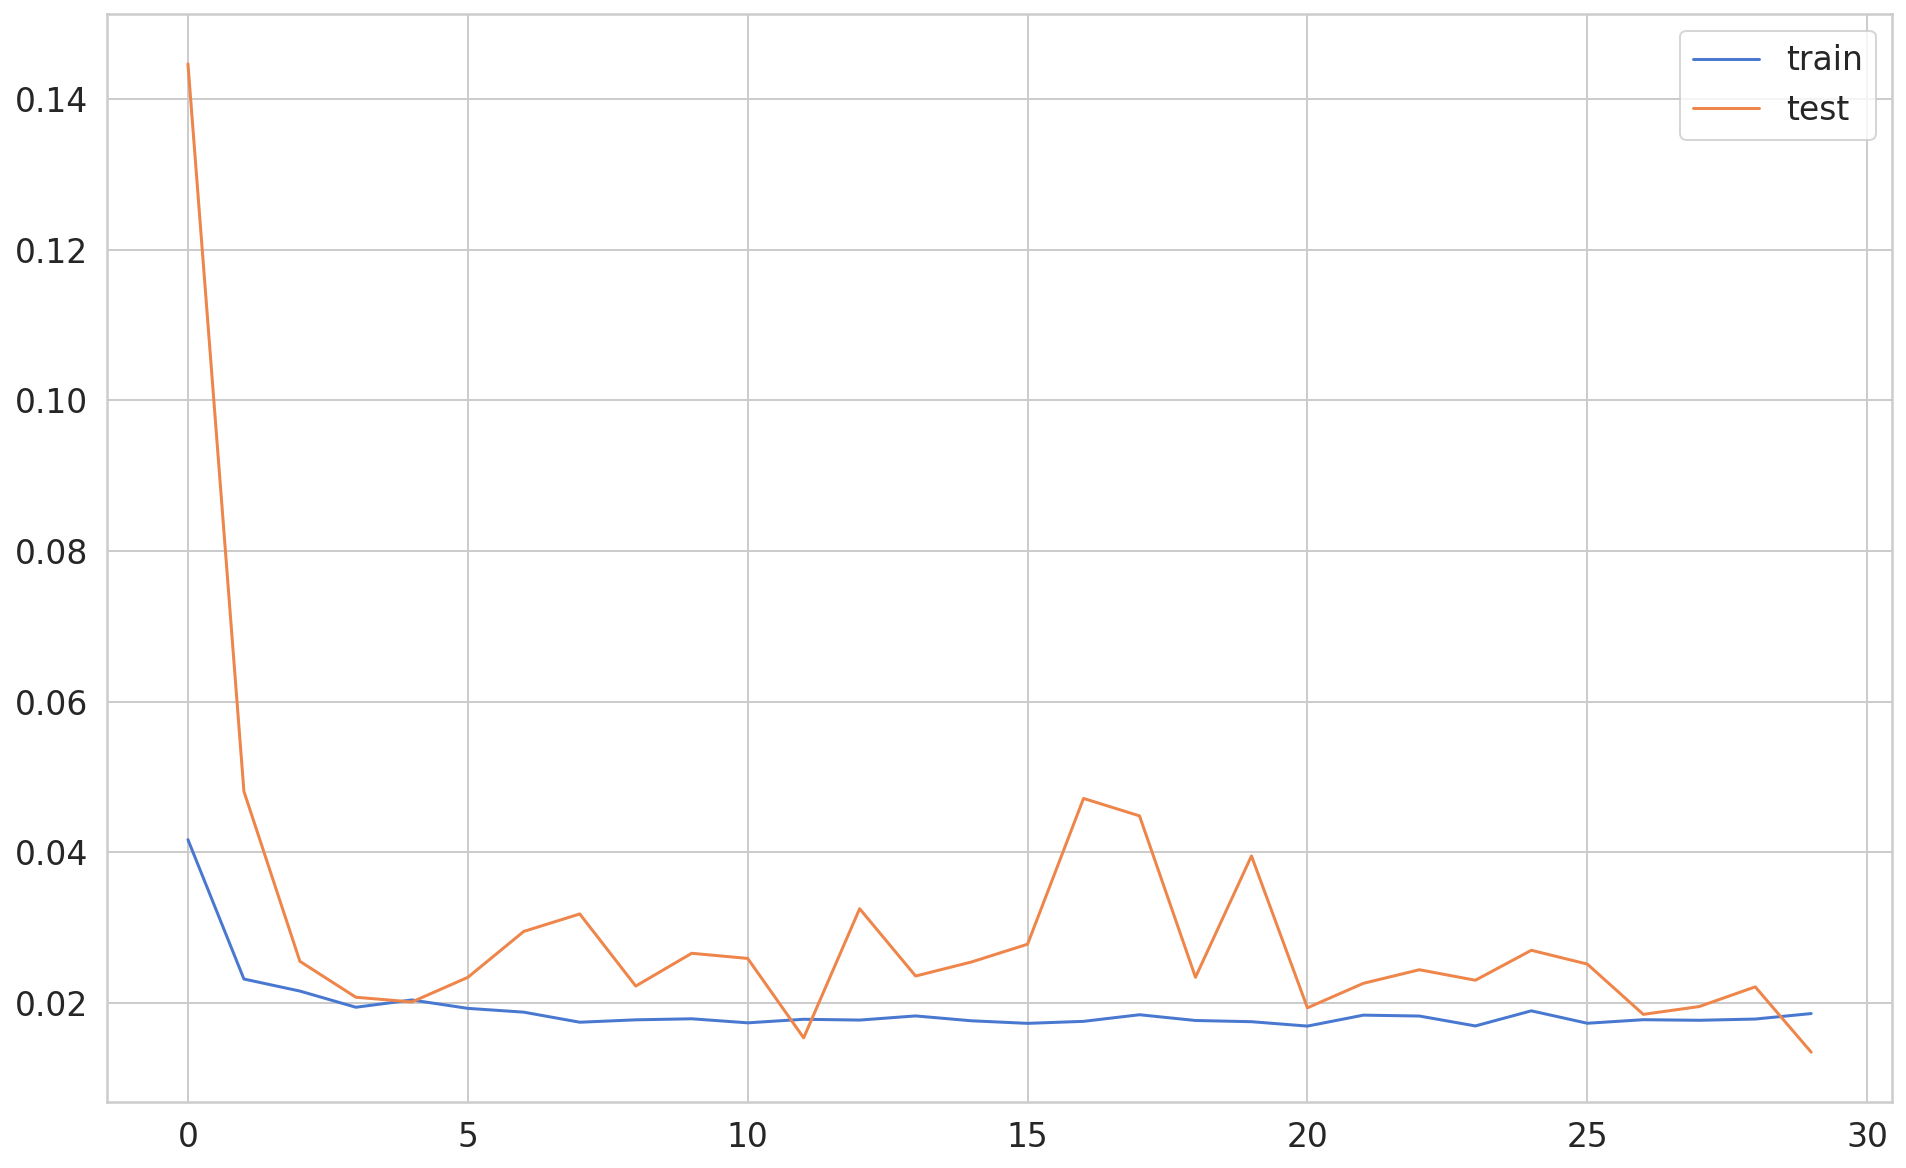

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

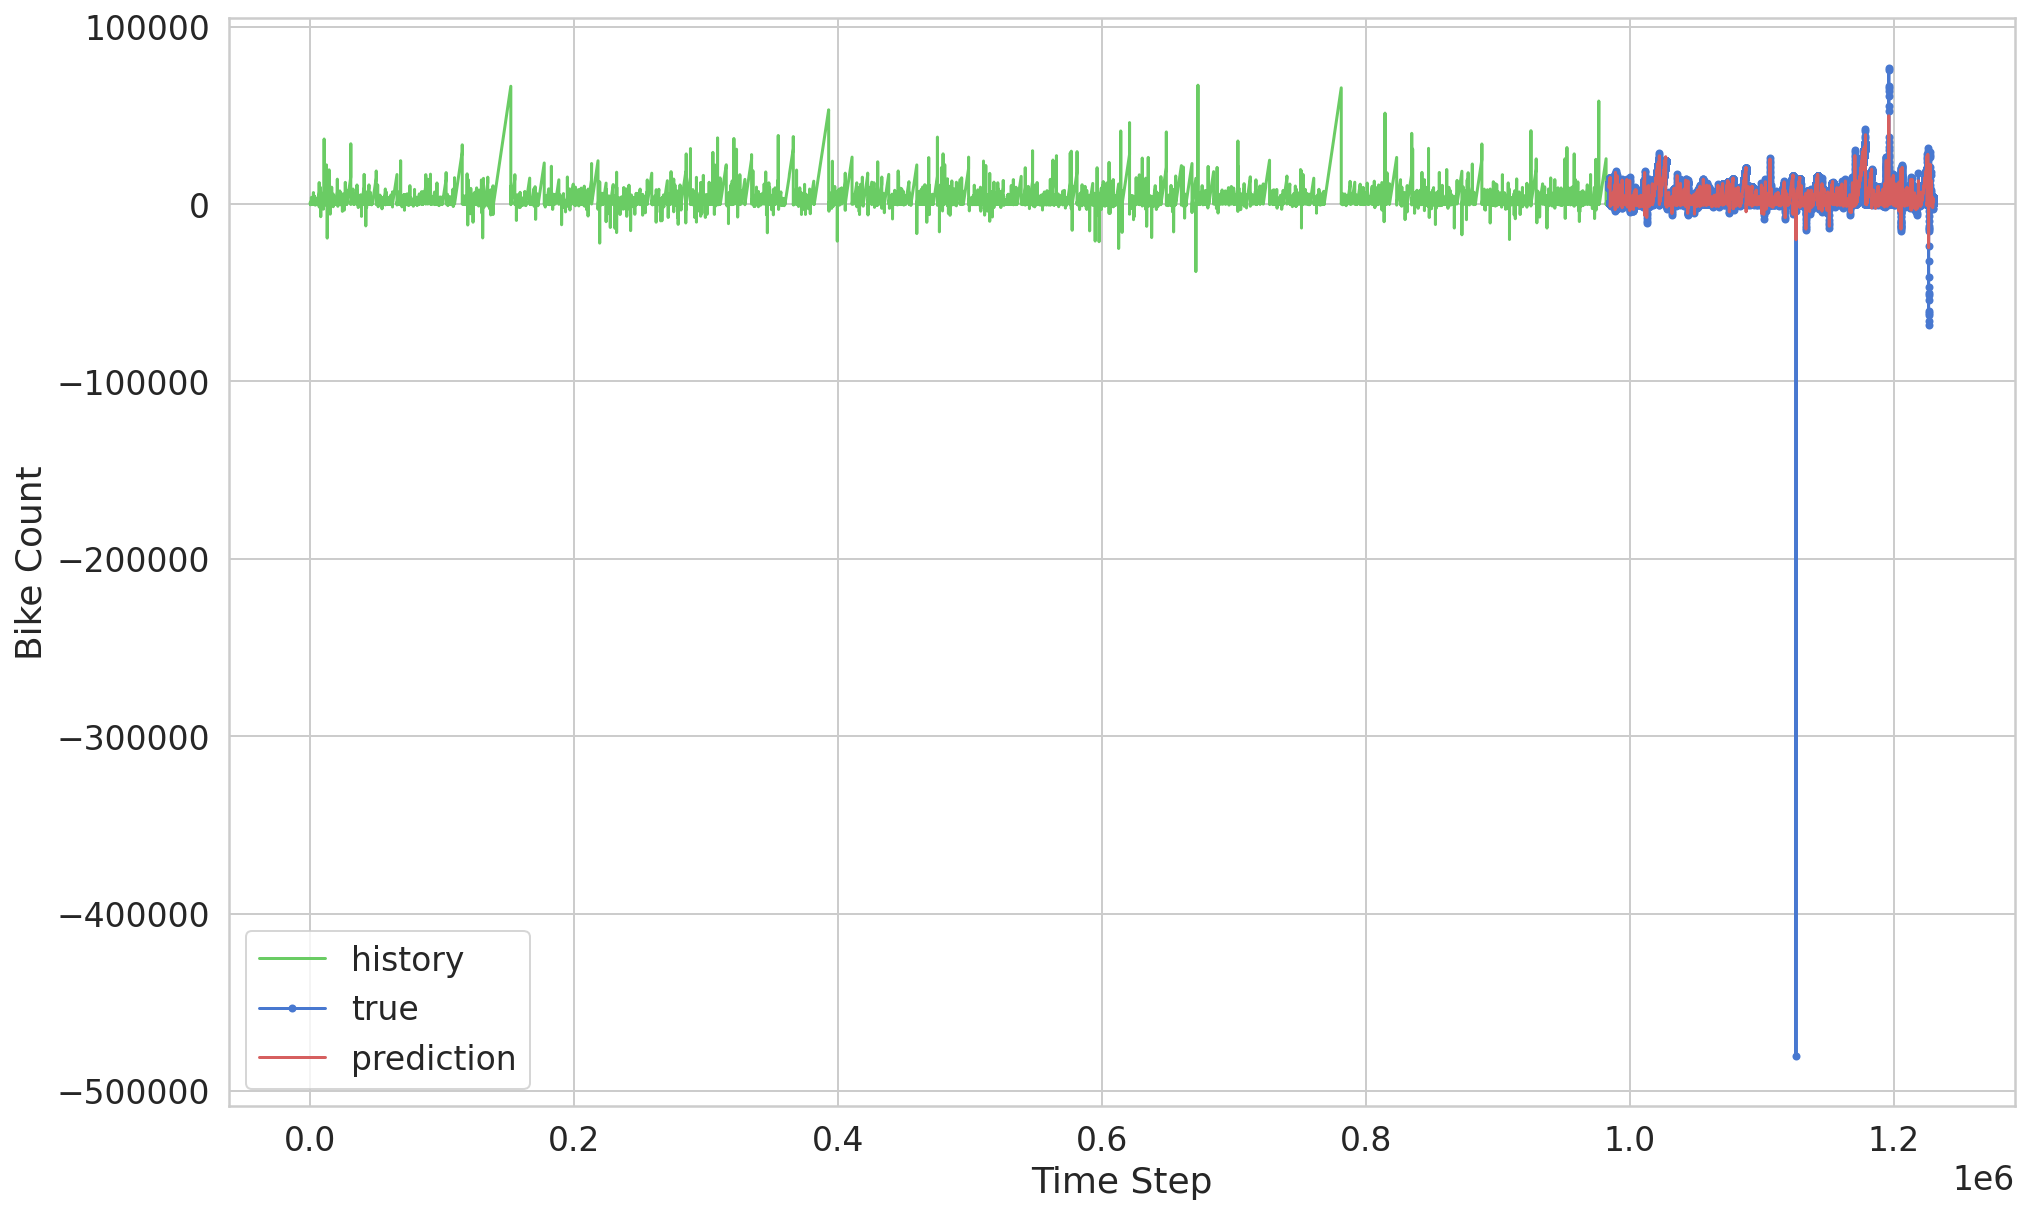

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

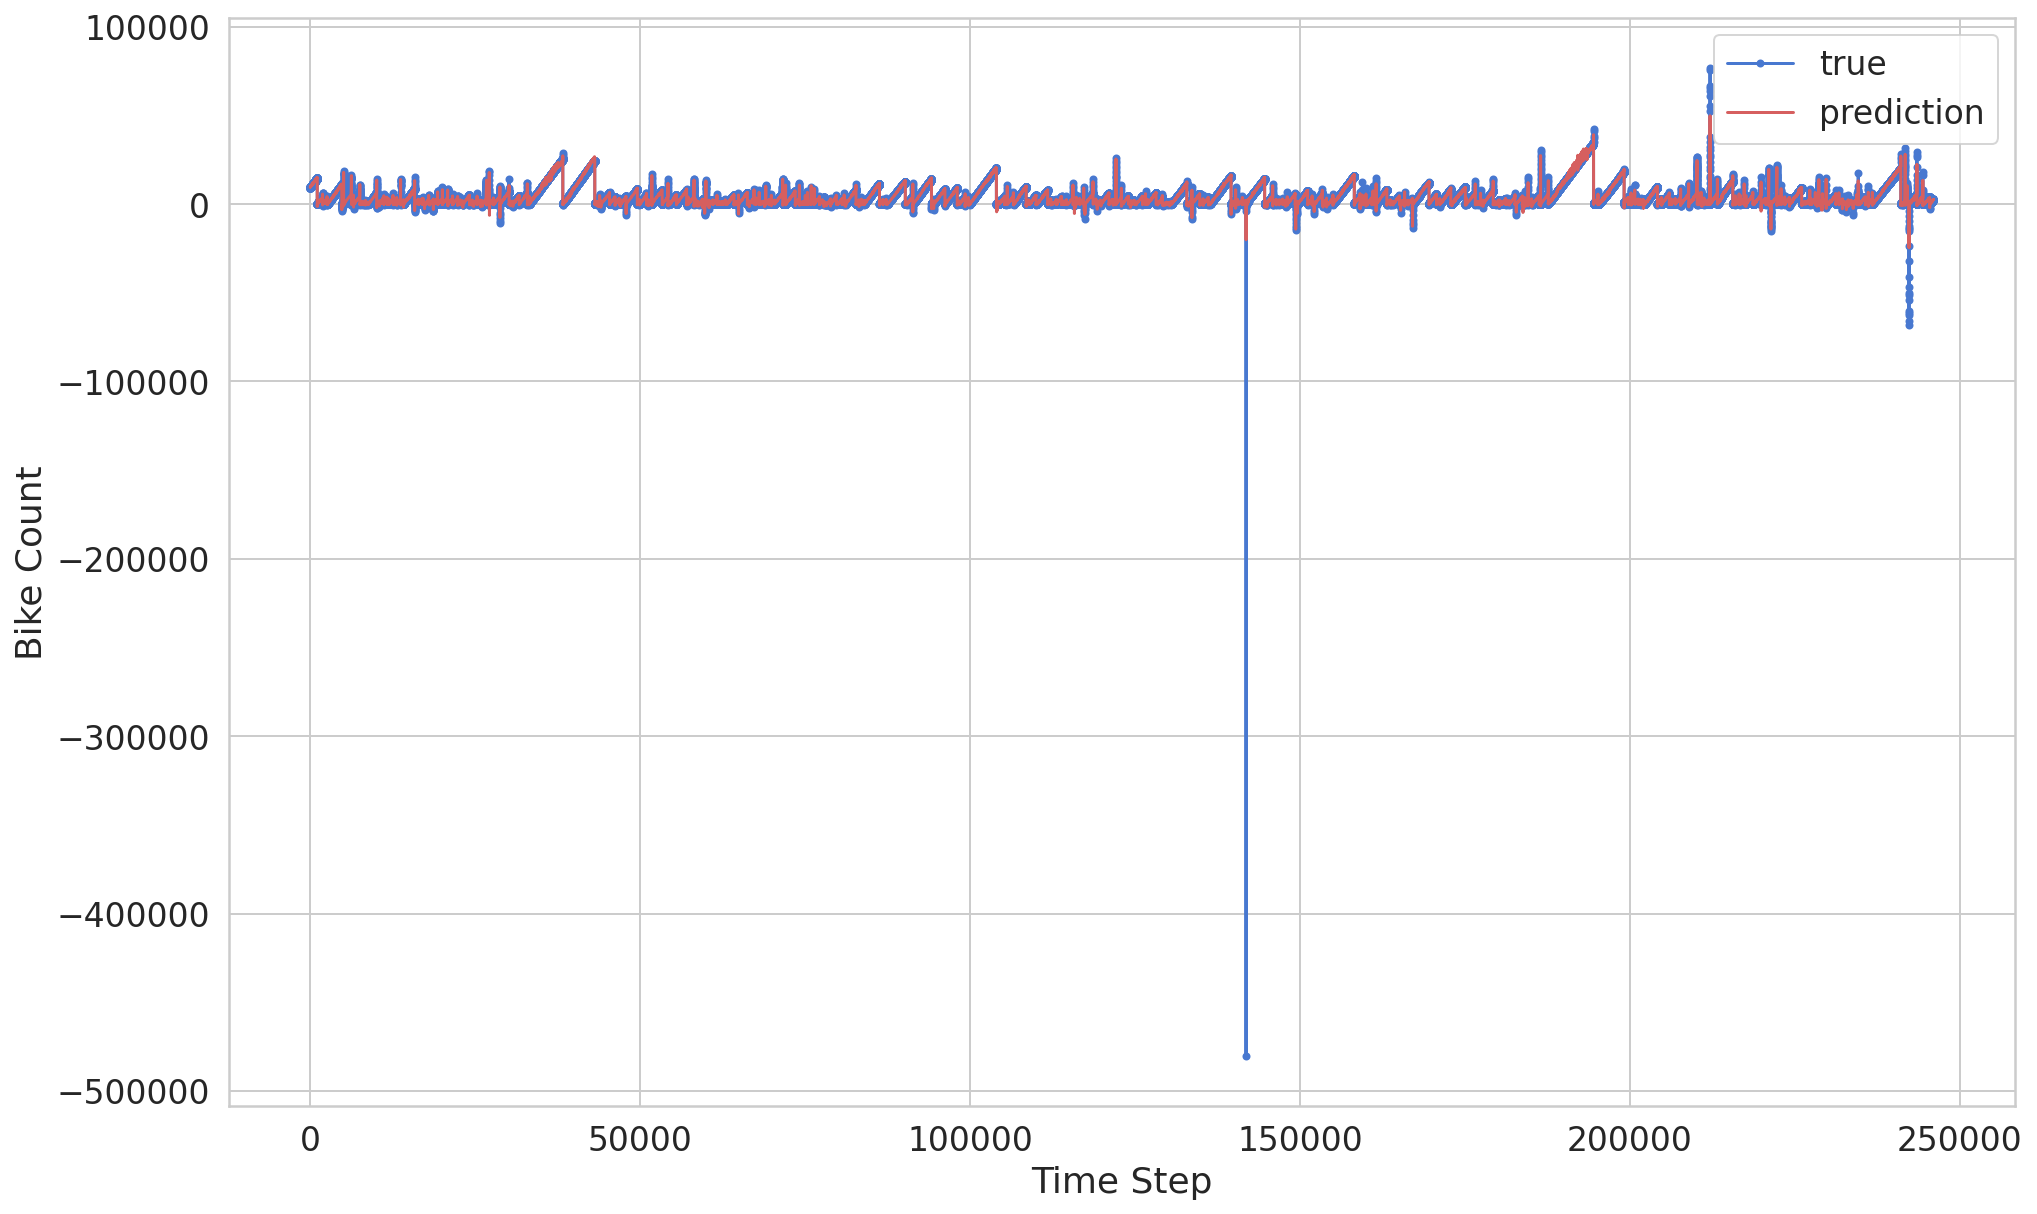

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,143870,7.0,0.0,-1.60,9.571429,-9.0,-0.089883,0.293301,0.0,0.172018,0.0
1,143870,10.0,0.0,-1.64,8.785714,-7.5,-0.089883,0.293301,0.0,0.172018,0.0
2,143870,12.0,0.0,-1.68,8.000000,-6.0,-0.089883,0.293301,0.0,0.172018,0.0
3,143870,17.0,0.0,-1.72,8.428571,-7.0,-0.089883,0.293301,0.0,0.172018,0.0
4,143870,22.0,0.0,-1.72,7.714286,-7.0,-0.089883,0.293301,0.0,0.172018,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1230089,3353113,2671.0,0.0,0.12,1.142857,0.0,-0.500779,-0.862651,0.3,-0.297488,0.0
1230090,3353113,2676.0,0.0,0.04,1.142857,0.0,-0.500779,-0.862651,0.3,-0.297488,0.0
1230091,3353113,2681.0,0.0,0.00,1.000000,0.0,-0.500779,-0.862651,0.3,-0.297488,0.0
1230092,3353113,2686.0,0.0,0.00,0.857143,0.0,-0.500779,-0.862651,0.3,-0.297488,0.0
